In [1]:
from rdkit import Chem
import rdkit.Chem.Lipinski as Lipinski
import rdkit.Chem.Crippen as Crippen
import pandas as pd
import numpy as np
import MDAnalysis as mda

In [5]:
mol = Chem.rdmolfiles.MolFromMol2File("../../dataset/refined-set/1a1e/1a1e_ligand.mol2")

In [6]:
#Hydrogen bond donors and acceptors in ligand https://www.rdkit.org/docs/source/rdkit.Chem.Lipinski.html
L_A = Lipinski.NumHAcceptors(mol)
L_D = Lipinski.NumHDonors(mol)

In [7]:
print(L_A)
print(L_D)

9
2


In [8]:
#Octanol-water logP https://www.rdkit.org/docs/source/rdkit.Chem.Crippen.html
LogP = Crippen.MolLogP(mol) 

In [9]:
print(LogP)

0.4552000000000014


In [10]:
#Molar Refractivity https://www.rdkit.org/docs/source/rdkit.Chem.Crippen.html
MR = Crippen.MolMR(mol)

In [11]:
print(MR)

131.67240000000004


In [12]:
#Wiener index http://www.scfbio-iitd.res.in/software/drugdesign/WINDEX/wienerindex.htm
def wiener_index(m):
    res = 0
    amat = Chem.GetDistanceMatrix(m)
    for i in range(m.GetNumAtoms()):
        for j in range(i+1,m.GetNumAtoms()):
            res += amat[i][j]
    return res

In [13]:
#Wiener index for the ligand
wmol = wiener_index(mol)
print(wmol)


5169.0


In [14]:
#Molecular weight of the ligand https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
MW = Chem.rdMolDescriptors.CalcExactMolWt(mol)
MW

552.2116399099099

In [116]:
#Calculate for all the ligands
indices = pd.read_csv("../../dataset/index_clean", delimiter=',',header=None, comment='#')

In [17]:
indices[0].values

array(['2tpi', '4tln', '1rnt', ..., '6k04', '6ic2', '6gxe'], dtype=object)

In [18]:
def wiener_index(m):
    res = 0
    amat = Chem.GetDistanceMatrix(m)
    for i in range(m.GetNumAtoms()):
        for j in range(i+1,m.GetNumAtoms()):
            res += amat[i][j]
    return res

In [ ]:
arr = np.zeros((len(indices[0]), 6))
for j,i in enumerate(indices[0]):
    #load sdf file
    #ignore errors
    try:
        mol = Chem.rdmolfiles.SDMolSupplier(f"../../dataset/refined-set/{i}/{i}_ligand.sdf")[0]
        MWe = Chem.rdMolDescriptors.CalcExactMolWt(mol)
        L_A = Lipinski.NumHAcceptors(mol)
        L_D = Lipinski.NumHDonors(mol)
        LogP = Crippen.MolLogP(mol) 
        MR = Crippen.MolMR(mol)
        wmol = wiener_index(mol)

    except:
        mol = Chem.rdmolfiles.MolFromMol2File(f"../../dataset/refined-set/{i}/{i}_ligand.mol2")  
        print("mol2")      
        MWe = Chem.rdMolDescriptors.CalcExactMolWt(mol)
        L_A = Lipinski.NumHAcceptors(mol)
        L_D = Lipinski.NumHDonors(mol)
        LogP = Crippen.MolLogP(mol) 
        MR = Crippen.MolMR(mol)
        wmol = wiener_index(mol)
    arr[j] = [MWe, L_A, L_D, LogP, MR, wmol]
  
    

In [20]:
arr

array([[ 2.31170319e+02,  2.00000000e+00,  3.00000000e+00,
        -1.31600000e-01,  6.05356000e+01,  4.61000000e+02],
       [ 1.47112804e+02,  2.00000000e+00,  3.00000000e+00,
        -8.51600000e-01,  3.60603000e+01,  1.30000000e+02],
       [ 3.63057999e+02,  1.00000000e+01,  6.00000000e+00,
        -2.56970000e+00,  7.64808000e+01,  1.23000000e+03],
       ...,
       [ 4.04151622e+02,  6.00000000e+00,  1.00000000e+00,
         4.72902000e+00,  1.14434700e+02,  2.13400000e+03],
       [ 4.36991713e+02,  8.00000000e+00,  5.00000000e+00,
         4.24100000e-01,  8.99438000e+01,  1.70100000e+03],
       [ 3.07062677e+02,  4.00000000e+00,  4.00000000e+00,
         1.68360000e+00,  7.85634000e+01,  1.08800000e+03]])

In [21]:
indices.shape

(5316, 3)

In [22]:
df = pd.DataFrame(arr, columns=['Molecular weight', 'Acceptors', 'Donors', 'LogP', 'Molecular Refractivity', 'Wiener index'])

In [23]:
df['Ids'] = indices[0]

In [24]:
df['Molecular weight'].value_counts()

Molecular weight
427.029415    36
547.235222    23
506.995745    20
441.008679    20
385.128865    17
              ..
269.124431     1
504.159139     1
135.079647     1
155.021858     1
307.062677     1
Name: count, Length: 3878, dtype: int64

In [25]:
df

,Molecular weight,Acceptors,Donors,LogP,Molecular Refractivity,Wiener index,Ids
0,231.170319,2.0,3.0,-0.13160,60.5356,461.0,2tpi
1,147.112804,2.0,3.0,-0.85160,36.0603,130.0,4tln
2,363.057999,10.0,6.0,-2.56970,76.4808,1230.0,1rnt
3,182.081170,2.0,3.0,-0.37020,46.1227,268.0,4ts1
4,519.213437,5.0,5.0,3.26060,135.1412,4249.0,4tmn
...,...,...,...,...,...,...,...
5311,253.050394,3.0,2.0,1.21620,64.9371,478.0,6d1i
5312,212.025563,3.0,1.0,0.53470,50.5625,260.0,6uh0
5313,404.151622,6.0,1.0,4.72902,114.4347,2134.0,6k04
5314,436.991713,8.0,5.0,0.42410,89.9438,1701.0,6ic2


In [26]:
import MDAnalysis as mda

In [28]:
protein = mda.Universe(f"../../dataset/refined-set/1a1e/1a1e_protein.pdb")

In [29]:
ligand = mda.Universe(f"../../dataset/refined-set/1a1e/1a1e_ligand.mol2")

In [30]:
ligand.atoms[0]

<Atom 1: C of type C.2 of resname ACE, resid 1 and segid SYSTEM>

In [31]:
complex = mda.Merge(protein.atoms, ligand.atoms)

In [32]:
ligname = ligand.residues[0].resname

In [33]:
pocket = complex.select_atoms(f"protein and around 6 resname {ligname}")

In [34]:
#Hydrogen bond donors an acceptors in protein https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/charge/#:~:text=3%20amino%20acids%20(arginine%2C%20lysine,atoms%20in%20their%20side%20chain

In [35]:
#Select the hydrogen bond donors of arginine:

ARG_hbond = pocket.select_atoms("name NH1 NH2 NE")

In [36]:
#Select the hydrongen bond donors of the aminoacid groups as in the paper:

PD_amide = len(pocket.select_atoms("name N"))


In [37]:
#donors
PD_positive = len(pocket.select_atoms("name NZ NE NH1 NH2 ND1 NE2"))        #Lysine, arginine and histidine
PD_neutral = len(pocket.select_atoms("name ND2 NE2"))     #asparagine,glutamine
PD_heteroatom = len(pocket.select_atoms("name NE1"))    #Tryptophan
PD_OH = len(pocket.select_atoms("name OG OG1 OH"))    #Serine, Threonine, Tyrosine

In [38]:
#acceptors
PA_amide = len(pocket.select_atoms("name O"))
PA_negative = len(pocket.select_atoms("name OD1 OD2 OE1 OE2"))   #Aspartate, Glutamate
PA_neutral = len(pocket.select_atoms("name OE1 OG2 OH OD1"))       #Asparagine, Glutamine, tyrosine, serine
PA_aromatic = len(pocket.select_atoms("name OH ND1 NE2"))   #Tyrosine, Histidine

In [40]:
#Construct a table with the logP and MR of every amino acid
amino_acid_names = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] # resname 3letter

#List of amino acid SMILES
SMILES_ASP = "C([C@@H](C(=O)O)N)C(=O)O" #aspartate #https://pubchem.ncbi.nlm.nih.gov/compound/Aspartic-Acid
SMILES_ALA = "C[C@@H](C(=O)O)N" #Alanine
SMILES_ARG = "C(C[C@@H](C(=O)O)N)CN=C(N)N" #Arginine
SMILES_ASN = "C([C@@H](C(=O)O)N)C(=O)N" #Asparagine
SMILES_CYS = "C([C@@H](C(=O)O)N)S" #Cysteine
SMILES_GLN = "C(CC(=O)N)[C@@H](C(=O)O)N" #Glutamine
SMILES_GLU = "C(CC(=O)O)[C@@H](C(=O)O)N" #Glutamate
SMILES_GLY = "C(C(=O)O)N" #Glycine
SMILES_HIS = "C1=C(NC=N1)C[C@@H](C(=O)O)N" #Histidine
SMILES_ILE = "CC[C@H](C)[C@@H](C(=O)O)N" #Isoleucine
SMILES_LEU = "CC(C)C[C@@H](C(=O)O)N" #Leucine
SMILES_LYS = "C(CCN)C[C@@H](C(=O)O)N" #Lysine
SMILES_MET = "CSCC[C@@H](C(=O)O)N" #Methionine
SMILES_PHE = "C1=CC=C(C=C1)C[C@@H](C(=O)O)N" #Phenylalanine
SMILES_PRO = "C1C[C@H](NC1)C(=O)O" #Proline
SMILES_SER = "C([C@@H](C(=O)O)N)O" #Serine
SMILES_THR = "C[C@H]([C@@H](C(=O)O)N)O" #Threonine
SMILES_TRP = "C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N" #Tryptophan
SMILES_TYR = "C1=CC(=CC=C1C[C@@H](C(=O)O)N)O" #Tyrosine
SMILES_VAL = "CC(C)[C@@H](C(=O)O)N" #Valine


#Mol object from SMILES
aspartic_mol = Chem.MolFromSmiles(SMILES_ASP) 
alanine_mol = Chem.MolFromSmiles(SMILES_ALA)
arginine_mol = Chem.MolFromSmiles(SMILES_ARG)
asparagine_mol = Chem.MolFromSmiles(SMILES_ASN)
cysteine_mol = Chem.MolFromSmiles(SMILES_CYS)
glutamine_mol = Chem.MolFromSmiles(SMILES_GLN)
glutamate_mol = Chem.MolFromSmiles(SMILES_GLU)
glycine_mol = Chem.MolFromSmiles(SMILES_GLY)
histidine_mol = Chem.MolFromSmiles(SMILES_HIS)
isoleucine_mol = Chem.MolFromSmiles(SMILES_ILE)
leucine_mol = Chem.MolFromSmiles(SMILES_LEU)
lysine_mol = Chem.MolFromSmiles(SMILES_LYS)
methionine_mol = Chem.MolFromSmiles(SMILES_MET)
phenylalanine_mol = Chem.MolFromSmiles(SMILES_PHE)
proline_mol = Chem.MolFromSmiles(SMILES_PRO)
serine_mol = Chem.MolFromSmiles(SMILES_SER)
threonine_mol = Chem.MolFromSmiles(SMILES_THR)
tryptophan_mol = Chem.MolFromSmiles(SMILES_TRP)
tyrosine_mol = Chem.MolFromSmiles(SMILES_TYR)
valine_mol = Chem.MolFromSmiles(SMILES_VAL)


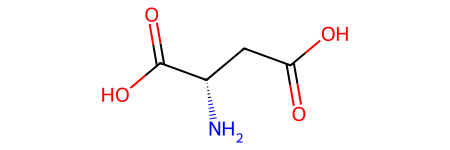

In [41]:
aspartic_mol # You can use this object to calculate the logP and MR of the amino acid

In [70]:

#Look up the smiles for every amino acid and calculate the logP and MR  and make a dictionary

#LogP
log_P_dict = {}
MR_dict = {}
logP_asp = Crippen.MolLogP(aspartic_mol)
logP_ala = Crippen.MolLogP(alanine_mol)
logP_arg = Crippen.MolLogP(arginine_mol)
logP_asn = Crippen.MolLogP(asparagine_mol)
logP_cys = Crippen.MolLogP(cysteine_mol)
logP_gln = Crippen.MolLogP(glutamine_mol)
logP_glu = Crippen.MolLogP(glutamate_mol)
logP_gly = Crippen.MolLogP(glycine_mol)
logP_his = Crippen.MolLogP(histidine_mol)
logP_ile = Crippen.MolLogP(isoleucine_mol)
logP_leu = Crippen.MolLogP(leucine_mol)
logP_lys = Crippen.MolLogP(lysine_mol)
logP_met = Crippen.MolLogP(methionine_mol)
logP_phe = Crippen.MolLogP(phenylalanine_mol)
logP_pro = Crippen.MolLogP(proline_mol)
logP_ser = Crippen.MolLogP(serine_mol)
logP_thr = Crippen.MolLogP(threonine_mol)
logP_trp = Crippen.MolLogP(tryptophan_mol)
logP_tyr = Crippen.MolLogP(tyrosine_mol)
logP_val = Crippen.MolLogP(valine_mol)

#MR
MR_asp = Crippen.MolMR(aspartic_mol)
MR_ala = Crippen.MolMR(alanine_mol)
MR_arg = Crippen.MolMR(arginine_mol)
MR_asn = Crippen.MolMR(asparagine_mol)
MR_cys = Crippen.MolMR(cysteine_mol)
MR_gln = Crippen.MolMR(glutamine_mol)
MR_glu = Crippen.MolMR(glutamate_mol)
MR_gly = Crippen.MolMR(glycine_mol)
MR_his = Crippen.MolMR(histidine_mol)
MR_ile = Crippen.MolMR(isoleucine_mol)
MR_leu = Crippen.MolMR(leucine_mol)
MR_lys = Crippen.MolMR(lysine_mol)
MR_met = Crippen.MolMR(methionine_mol)
MR_phe = Crippen.MolMR(phenylalanine_mol)
MR_pro = Crippen.MolMR(proline_mol)
MR_ser = Crippen.MolMR(serine_mol)
MR_thr = Crippen.MolMR(threonine_mol)
MR_trp = Crippen.MolMR(tryptophan_mol)
MR_tyr = Crippen.MolMR(tyrosine_mol)
MR_val = Crippen.MolMR(valine_mol)


log_P_dict['ASP'] = logP_asp
log_P_dict['ALA'] = logP_ala
log_P_dict['ARG'] = logP_arg
log_P_dict['ASN'] = logP_asn
log_P_dict['CYS'] = logP_cys
log_P_dict['GLN'] = logP_gln
log_P_dict['GLU'] = logP_glu
log_P_dict['GLY'] = logP_gly
log_P_dict['HIS'] = logP_his
log_P_dict['ILE'] = logP_ile
log_P_dict['LEU'] = logP_leu
log_P_dict['LYS'] = logP_lys
log_P_dict['MET'] = logP_met
log_P_dict['PHE'] = logP_phe
log_P_dict['PRO'] = logP_pro
log_P_dict['SER'] = logP_ser
log_P_dict['THR'] = logP_thr
log_P_dict['TRP'] = logP_trp
log_P_dict['TYR'] = logP_tyr
log_P_dict['VAL'] = logP_val

MR_dict['ASP'] = MR_asp
MR_dict['ALA'] = MR_ala
MR_dict['ARG'] = MR_arg
MR_dict['ASN'] = MR_asn
MR_dict['CYS'] = MR_cys
MR_dict['GLN'] = MR_gln
MR_dict['GLU'] = MR_glu
MR_dict['GLY'] = MR_gly
MR_dict['HIS'] = MR_his
MR_dict['ILE'] = MR_ile
MR_dict['LEU'] = MR_leu
MR_dict['LYS'] = MR_lys
MR_dict['MET'] = MR_met
MR_dict['PHE'] = MR_phe
MR_dict['PRO'] = MR_pro
MR_dict['SER'] = MR_ser
MR_dict['THR'] = MR_thr
MR_dict['TRP'] = MR_trp
MR_dict['TYR'] = MR_tyr
MR_dict['VAL'] = MR_val


In [ ]:
#Make a dictionary of the amino acids with their smiles
smiles_dict = {
    "ASP": "C([C@@H](C(=O)O)N)C(=O)O",
    "GLU": "C(CC(=O)O)[C@@H](C(=O)O)N",
    "LYS": "C(CCN)C[C@@H](C(=O)O)N",
    "ARG": "C(C[C@@H](C(=O)O)N)CN=C(N)N",
    "HIS": "C1=C(NC=N1)C[C@@H](C(=O)O)N",
    "SER": "C([C@@H](C(=O)O)N)O",
    "THR": "C[C@H]([C@@H](C(=O)O)N)O",
    "ASN": "C([C@@H](C(=O)O)N)C(=O)N",
    "GLN": "C(CC(=O)N)[C@@H](C(=O)O)N",
    "CYS": "C([C@@H](C(=O)O)N)S",
    "MET": "CSCC[C@@H](C(=O)O)N",
    "TYR": "C1=CC(=CC=C1C[C@@H](C(=O)O)N)O",
    "TRP": "C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N",
    "PHE": "C1=CC=C(C=C1)C[C@@H](C(=O)O)N",
    "GLY": "C(C(=O)O)N",
    "PRO": "C1C[C@H](NC1)C(=O)O",
    "ALA": "C[C@@H](C(=O)O)N",
    "VAL": "CC(C)[C@@H](C(=O)O)N",
    "LEU": "CC(C)C[C@@H](C(=O)O)N",
    "ILE": "CC[C@H](C)[C@@H](C(=O)O)N"
}

In [44]:
log_P_dict

{'ASP': -1.1269999999999998,
 'ALA': -0.5817999999999999,
 'ARG': -1.548099999999999,
 'ASN': -1.7262999999999993,
 'CYS': -0.6719,
 'GLN': -1.336199999999999,
 'GLU': -0.736899999999999,
 'GLY': -0.9702999999999999,
 'HIS': -0.6358999999999995,
 'ILE': 0.44439999999999996,
 'LEU': 0.44439999999999996,
 'LYS': -0.47269999999999873,
 'MET': 0.15140000000000003,
 'PHE': 0.641,
 'PRO': -0.17700000000000032,
 'SER': -1.6093999999999995,
 'THR': -1.2208999999999997,
 'TRP': 1.1222999999999996,
 'TYR': 0.3465999999999994,
 'VAL': 0.05430000000000007}

In [45]:
MR_dict

{'ASP': 27.863999999999997,
 'ALA': 21.285200000000003,
 'ARG': 45.522,
 'ASN': 29.422600000000003,
 'CYS': 29.464199999999998,
 'GLN': 34.03959999999999,
 'GLU': 32.480999999999995,
 'GLY': 16.6902,
 'HIS': 37.902899999999995,
 'ILE': 35.06619999999998,
 'LEU': 35.06619999999998,
 'LYS': 38.5166,
 'MET': 38.61019999999999,
 'PHE': 45.75720000000001,
 'PRO': 28.660499999999992,
 'SER': 22.697000000000003,
 'THR': 27.291999999999994,
 'TRP': 57.613900000000015,
 'TYR': 47.42200000000001,
 'VAL': 30.44919999999999}

In [73]:
amino_acid_names_list = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
arr = np.zeros((len(indices[0]), 11))
for j,i in enumerate(indices[0]):
    protein = mda.Universe(f"../../dataset/refined-set/{i}/{i}_protein.pdb")
    ligand = mda.Universe(f"../../dataset/refined-set/{i}/{i}_ligand.mol2")

    ligname = 'LIG'
    for lgnm in ligand.residues:
        lgnm.resname = 'LIG'
    complex = mda.Merge(protein.atoms, ligand.atoms)
    pocket = complex.select_atoms(f"protein and around 6 resname {ligname}")
    PD_amide = len(pocket.select_atoms("name N"))
    PD_positive = len(pocket.select_atoms("name NZ NE NH1 NH2 ND1 NE2"))        #Lysine, arginine and histidine
    PD_neutral = len(pocket.select_atoms("name ND2 NE2"))     #asparagine,glutamine
    PD_heteroatom = len(pocket.select_atoms("name NE1"))    #Tryptophan
    PD_OH = len(pocket.select_atoms("name OG OG1 OH"))    #Serine, Threonine, Tyrosine
    PA_amide = len(pocket.select_atoms("name O"))
    PA_negative = len(pocket.select_atoms("name OD1 OD2 OE1 OE2"))   #Aspartate, Glutamate
    PA_neutral = len(pocket.select_atoms("name OE1 OG2 OH OD1"))       #Asparagine, Glutamine, tyrosine, serine
    PA_aromatic = len(pocket.select_atoms("name OH ND1 NE2"))   #Tyrosine, Histidine
    amino_acids = [residue.resname for residue in pocket.residues]
    P_logp = np.mean([log_P_dict[amino_acid] for amino_acid in amino_acids])
    P_MR = np.mean([MR_dict[amino_acid] for amino_acid in amino_acids])
    arr[j] = [PD_amide, PD_positive, PD_neutral, PD_heteroatom, PD_OH, PA_amide, PA_negative, PA_neutral, PA_aromatic, P_logp, P_MR]
    print(arr[j])
    


In [165]:
df['PD_amide'] = arr[:,0]
df['PD_positive'] = arr[:,1]
df['PD_neutral'] = arr[:,2]
df['PD_heteroatom'] = arr[:,3]
df['PD_OH'] = arr[:,4]
df['PA_amide'] = arr[:,5]
df['PA_negative'] = arr[:,6]
df['PA_neutral'] = arr[:,7]
df['PA_aromatic'] = arr[:,8]
df['P_logp'] = arr[:,9]
df['P_MR'] = arr[:,10]


In [166]:
df

,Molecular weight,Acceptors,Donors,LogP,Molecular Refractivity,Wiener index,Ids,PD_amide,PD_positive,PD_neutral,PD_heteroatom,PD_OH,PA_amide,PA_negative,PA_neutral,PA_aromatic,Free energy,P_logp,P_MR
0,231.170319,2.0,3.0,-0.13160,60.5356,461.0,2tpi,24.0,0.0,0.0,0.0,5.0,23.0,5.0,4.0,1.0,-5.874825,-0.665612,29.440791
1,147.112804,2.0,3.0,-0.85160,36.0603,130.0,4tln,6.0,9.0,4.0,0.0,2.0,6.0,6.0,4.0,7.0,-5.072544,-0.403714,34.962933
2,363.057999,10.0,6.0,-2.56970,76.4808,1230.0,1rnt,9.0,6.0,6.0,0.0,3.0,9.0,9.0,10.0,7.0,-7.070675,-0.619947,36.111405
3,182.081170,2.0,3.0,-0.37020,46.1227,268.0,4ts1,11.0,4.0,5.0,1.0,4.0,12.0,11.0,10.0,5.0,-6.727787,-0.498970,31.695033
4,519.213437,5.0,5.0,3.26060,135.1412,4249.0,4tmn,16.0,9.0,5.0,1.0,6.0,16.0,13.0,10.0,9.0,-13.859616,-0.503965,34.127585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5311,253.050394,3.0,2.0,1.21620,64.9371,478.0,6d1i,6.0,9.0,5.0,0.0,0.0,5.0,4.0,2.0,8.0,-5.577268,-0.570889,33.634874
5312,212.025563,3.0,1.0,0.53470,50.5625,260.0,6uh0,5.0,7.0,6.0,1.0,3.0,6.0,5.0,5.0,8.0,-8.272838,-0.393956,34.876296
5313,404.151622,6.0,1.0,4.72902,114.4347,2134.0,6k04,10.0,2.0,2.0,1.0,2.0,9.0,3.0,4.0,4.0,-10.960875,-0.186890,36.583310
5314,436.991713,8.0,5.0,0.42410,89.9438,1701.0,6ic2,8.0,7.0,6.0,1.0,3.0,10.0,4.0,4.0,8.0,-8.229820,-0.330392,33.531504


In [139]:
#Separate the number from str in indices[2] and assign to number and unit columns respectively
indices['number'] = [var[:-2] for var in indices[2]]
indices['unit'] = [var[-2:] for var in indices[2]]

In [140]:
indices

,0,1,2,number,unit
0,2tpi,Kd,49uM,49,uM
1,4tln,Ki,190uM,190,uM
2,1rnt,Kd,6.5uM,6.5,uM
3,4ts1,Kd,11.6uM,11.6,uM
4,4tmn,Ki,0.068nM,0.068,nM
...,...,...,...,...,...
5311,6d1i,Ki,81uM,81,uM
5312,6uh0,Ki,853.1nM,853.1,nM
5313,6k04,Ki,9.1nM,9.1,nM
5314,6ic2,Ki,917.4nM,917.4,nM


In [141]:
indices['unit'].value_counts()

unit
uM    2672
nM    2225
mM     286
pM     132
fM       1
Name: count, dtype: int64

In [145]:
#Create empty molar column
indices['Molar'] = np.nan


In [ ]:
#Convert the number to molar according to the unit
indices['number'] = indices['number'].astype(float)
indices['unit'] = indices['unit'].astype(str)
for i in range(len(indices)):
    if indices['unit'][i] == 'mM':
        indices['Molar'][i] = indices['number'][i]/1000
    elif indices['unit'][i] == 'nM':
        indices['Molar'][i] = indices['number'][i]/1000000000
    elif indices['unit'][i] == 'uM':
        indices['Molar'][i] = indices['number'][i]/1000000
    elif indices['unit'][i] == 'pM':
        indices['Molar'][i] = indices['number'][i]/1000000000000
    elif indices['unit'][i] == 'fM':
        indices['Molar'][i] = indices['number'][i]/1000000000000000
    else:
        indices['number'][i] = indices['number'][i]

In [148]:
#Convert the Molar to free energy in kcal/mol
indices['Molar'] = indices['Molar'].astype(float)
indices['Free energy'] = 0.592 * np.log(indices['Molar']) #RT = 0.592 kcal/mol at 298K

In [149]:
indices

,0,1,2,number,unit,Molar,Free energy
0,2tpi,Kd,49uM,49.000,uM,4.900000e-05,-5.874825
1,4tln,Ki,190uM,190.000,uM,1.900000e-04,-5.072544
2,1rnt,Kd,6.5uM,6.500,uM,6.500000e-06,-7.070675
3,4ts1,Kd,11.6uM,11.600,uM,1.160000e-05,-6.727787
4,4tmn,Ki,0.068nM,0.068,nM,6.800000e-11,-13.859616
...,...,...,...,...,...,...,...
5311,6d1i,Ki,81uM,81.000,uM,8.100000e-05,-5.577268
5312,6uh0,Ki,853.1nM,853.100,nM,8.531000e-07,-8.272838
5313,6k04,Ki,9.1nM,9.100,nM,9.100000e-09,-10.960875
5314,6ic2,Ki,917.4nM,917.400,nM,9.174000e-07,-8.229820


In [150]:
df['Free energy'] = indices['Free energy']

In [167]:
df

,Molecular weight,Acceptors,Donors,LogP,Molecular Refractivity,Wiener index,Ids,PD_amide,PD_positive,PD_neutral,PD_heteroatom,PD_OH,PA_amide,PA_negative,PA_neutral,PA_aromatic,Free energy,P_logp,P_MR
0,231.170319,2.0,3.0,-0.13160,60.5356,461.0,2tpi,24.0,0.0,0.0,0.0,5.0,23.0,5.0,4.0,1.0,-5.874825,-0.665612,29.440791
1,147.112804,2.0,3.0,-0.85160,36.0603,130.0,4tln,6.0,9.0,4.0,0.0,2.0,6.0,6.0,4.0,7.0,-5.072544,-0.403714,34.962933
2,363.057999,10.0,6.0,-2.56970,76.4808,1230.0,1rnt,9.0,6.0,6.0,0.0,3.0,9.0,9.0,10.0,7.0,-7.070675,-0.619947,36.111405
3,182.081170,2.0,3.0,-0.37020,46.1227,268.0,4ts1,11.0,4.0,5.0,1.0,4.0,12.0,11.0,10.0,5.0,-6.727787,-0.498970,31.695033
4,519.213437,5.0,5.0,3.26060,135.1412,4249.0,4tmn,16.0,9.0,5.0,1.0,6.0,16.0,13.0,10.0,9.0,-13.859616,-0.503965,34.127585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5311,253.050394,3.0,2.0,1.21620,64.9371,478.0,6d1i,6.0,9.0,5.0,0.0,0.0,5.0,4.0,2.0,8.0,-5.577268,-0.570889,33.634874
5312,212.025563,3.0,1.0,0.53470,50.5625,260.0,6uh0,5.0,7.0,6.0,1.0,3.0,6.0,5.0,5.0,8.0,-8.272838,-0.393956,34.876296
5313,404.151622,6.0,1.0,4.72902,114.4347,2134.0,6k04,10.0,2.0,2.0,1.0,2.0,9.0,3.0,4.0,4.0,-10.960875,-0.186890,36.583310
5314,436.991713,8.0,5.0,0.42410,89.9438,1701.0,6ic2,8.0,7.0,6.0,1.0,3.0,10.0,4.0,4.0,8.0,-8.229820,-0.330392,33.531504


In [168]:
df.to_csv("features.csv", index=False)

In [ ]:
#Put your imports here so you don't have to re run the whole script
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.svm import SVR
import seaborn as sns
import sklearn
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# sudo pip install xgboost
import xgboost

warnings.filterwarnings('ignore')

In [ ]:
#Try implementing SVM (https://medium.com/@niousha.rf/support-vector-regressor-theory-and-coding-exercise-in-python-ca6a7dfda927), LR (https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/), RF (https://www.geeksforgeeks.org/random-forest-regression-in-python/), and XGBoost (https://machinelearningmastery.com/xgboost-for-regression/)
#You can load the calculated features with df = pd.read_csv("features.csv") and then use the features to train the models
#The target will be the Free energy column, the rest will be the features
#reduces overfitting

df = pd.read_csv("features.csv")

X = df.iloc[:, :17]
Y = df['Free energy']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
train, test = train_test_split(df, test_size=0.3, random_state=0)
train = train.sort_values('Free energy')

#Scales X-data, fit() method expects a 2D array-like input
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_lin = SVR(kernel = 'linear')
#svr_rbf = SVR(kernel = 'rbf')
#svr_poly = SVR(kernel = 'poly')

svr_lin.fit(X_train_scaled, y_train)
#svr_rbf.fit(X_train_scaled, y_train)
#svr_poly.fit(X_train_scaled, y_train)

train['linear_svr_pred'] = svr_lin.predict(X_train_scaled)
#train['rbf_svr_pred'] = svr_rbf.predict(X_train_scaled)
#train['poly_svr_pred'] = svr_poly.predict(X_train_scaled)




: 

In [ ]:
#Try implementing LR (https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/), 
#You can load the calculated features with df = pd.read_csv("features.csv") and then use the features to train the models
#The target will be the Free energy column, the rest will be the features

df = pd.read_csv("features.csv")

X = df.iloc[:, :17]
Y = df['Free energy']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)
X_test = np.array(X_test)
y_test = np.array(y_test)

logit = LogisticRegression()
logit.fit(X_train, y_train)
y_test_pred = logit.predict(X_test)

#np.mean(y_test_pred == y_test)

In [ ]:
#Try implementing, RF (https://www.geeksforgeeks.org/random-forest-regression-in-python/) 
#You can load the calculated features with df = pd.read_csv("features.csv") and then use the features to train the models
#The target will be the Free energy column, the rest will be the features
#combines multiple "trees"

df = pd.read_csv("features.csv")

X = df.iloc[:, :17]
Y = df['Free energy']

label_encoder = LabelEncoder()
x_categorical = df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(x, Y)




: 

In [ ]:
#Try implementing XGBoost (https://machinelearningmastery.com/xgboost-for-regression/)
#You can load the calculated features with df = pd.read_csv("features.csv") and then use the features to train the models
#The target will be the Free energy column, the rest will be the features


df = pd.read_csv("features.csv")

x, Y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=0)